In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("The most recent date in the dataset is:", most_recent_date)

The most recent date in the dataset is: 2017-08-23


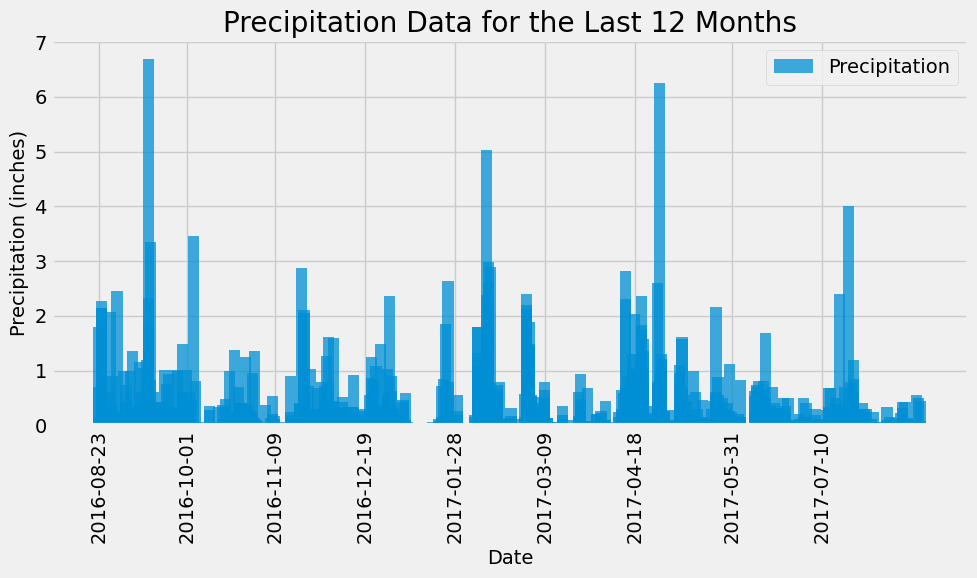

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')
#print(precipitation_df.head())

# Define the dates for which you want vertical labels
vertical_labels = [
    '2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28',
    '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10'
]

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=5, label='Precipitation', alpha=0.75)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')

# Set the custom ticks and labels for vertical dates
plt.xticks(vertical_labels, rotation='vertical')

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
print("\nSummary Statistics for Precipitation Data:")
summary_stats


Summary Statistics for Precipitation Data:


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("\nTotal number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("\nMost Active Stations (Station, Count):")
for station, count in most_active_stations:
    print(f"{station}: {count}")


Most Active Stations (Station, Count):
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

print("\nTemperature Statistics for the Most Active Station:")
print(f"Lowest Temperature: {temperature_stats[0][0]}°F")
print(f"Highest Temperature: {temperature_stats[0][1]}°F")
print(f"Average Temperature: {temperature_stats[0][2]:.2f}°F")


Temperature Statistics for the Most Active Station:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


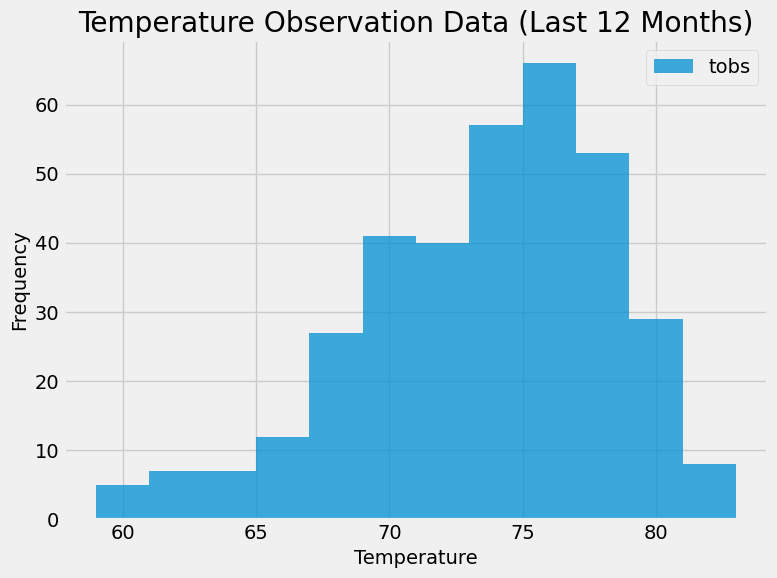

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()
# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the temperature data as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='tobs', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [24]:
# Close Session
session.close()